<a href="https://colab.research.google.com/github/Recommendation-System-Project/Recommendation-system/blob/main/DR_coat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import time

In [3]:
def get_data():
  observed_r = np.genfromtxt("data/train.ascii", dtype=None) # observed ratings
  observed_r = observed_r.astype('float')
  observed_r[observed_r == 0] = np.nan
    
  predicted_r = np.random.randint(1,5,size=observed_r.shape) # predicted rating
    
  observed_e = predicted_r - observed_r # e_ui
  propensities = np.genfromtxt("data/our_propensities.ascii", dtype=None) # propensities for all user item pairs

  O_mask = np.int64(observed_r > 0)

  item_features = np.genfromtxt("data/item_features_encoded.ascii", dtype=None)
  user_features = np.genfromtxt("data/user_features.ascii", dtype=None)
   
  return observed_r, predicted_r, observed_e, propensities, O_mask, item_features, user_features

In [4]:
observed_r, predicted_r, observed_e, propensities, O_mask, item_features, user_features = get_data()

In [5]:
features_matrix = []
for u in range(O_mask.shape[0]):
  for i in range(O_mask.shape[1]):
    user_f = user_features[u]
    item_f = item_features[i]
    observed = np.concatenate((user_f, item_f))
    features_matrix.append(observed)
features_matrix = np.array(features_matrix)
features_matrix.shape

(87000, 35)

In [7]:
observed_features = []
for i in O_mask.flatten():
  if i == 1:
    observed_features.append(features_matrix[i])
observed_features = np.array(observed_features)
observed_features.shape

(6960, 35)

In [19]:
observed_r_1d = observed_r.flatten()
observed_r_1d = observed_r_1d[~np.isnan(observed_r_1d)]

observed_e_1d = observed_e.flatten()
observed_e_1d = observed_e_1d[~np.isnan(observed_e_1d)]

predicted_r_1d = np.array(predicted_r*O_mask).flatten()
predicted_r_1d = predicted_r_1d[predicted_r_1d != 0]

propensities_1d = np.array(propensities*O_mask).flatten()
propensities_1d = propensities_1d[propensities_1d != 0]

In [9]:
def loss_emputation(w,y,r,e,p):
  #l(w,y) = (w*rui^2 - 2*w*y*rui + y^2 - eui)^2 / pui
  return  ((w*r)**2 - 2*w*y*r + y**2 - e)**2/p

In [10]:
#r: rui^{hat}
#e = eui
#p = pui^{hat}
def gradient_descent(w, y, le, observed_e, predicted_r, propensities, max_iter, lr=0.1):
  w.requires_grad = True
  y.requires_grad = True
  m = observed_e.shape[0]
  theta = [w.item(), y.item()]
  iter_list = []
  loss_list = []
  for i in range(max_iter):
    loss = 0
    rand1 = np.random.randint(0, m, 1)
    r = torch.from_numpy(predicted_r[rand1]).type(torch.float32)
    e = torch.from_numpy(observed_e[rand1]).type(torch.float32)
    p = torch.from_numpy(propensities[rand1]).type(torch.float32)

    output = le(w,y,r,e,p)
    output.backward()
    w.data -= lr * w.grad
    y.data -= lr * y.grad
    w.grad.fill_(0)
    y.grad.fill_(0)

    for j in range(m):
      every_loss = le(w,y,predicted_r[j],observed_e[j],propensities[j]).item()
      loss = loss + every_loss
    theta[0] = w.item()
    theta[1] = y.item()
    print("iter_count: ", i, "the loss: ",loss)
    print("theta:", theta)
    iter_list.append(i)
    loss_list.append(loss)
      
  plt.plot(iter_list, loss_list)
  plt.xlabel("iter")
  plt.ylabel("loss")
  plt.show()
  return theta, loss

In [11]:
torch.manual_seed(10)
w = torch.randn(1)
y = torch.randn(1)
lr = 0.0001
max_iter = 1000

iter_count:  0 the loss:  225907.01598370727
theta: [-0.5957640409469604, -1.0140860080718994]
iter_count:  1 the loss:  224849.29806624283
theta: [-0.5875008702278137, -1.016151785850525]
iter_count:  2 the loss:  229247.1907619713
theta: [-0.6102460026741028, -1.0085700750350952]
iter_count:  3 the loss:  228895.01186959213
theta: [-0.609036922454834, -1.008872389793396]
iter_count:  4 the loss:  228992.1086205151
theta: [-0.6093467473983765, -1.0085625648498535]
iter_count:  5 the loss:  229629.18509312347
theta: [-0.6114083528518677, -1.007531762123108]
iter_count:  6 the loss:  243607.51308470033
theta: [-0.6413963437080383, -1.0000348091125488]
iter_count:  7 the loss:  225624.76655072556
theta: [-0.5939830541610718, -1.0118881464004517]
iter_count:  8 the loss:  226929.66843945673
theta: [-0.6007117033004761, -1.0051594972610474]
iter_count:  9 the loss:  224022.74985595432
theta: [-0.5734204649925232, -1.0142565965652466]
iter_count:  10 the loss:  224035.31138240872
theta: [-0

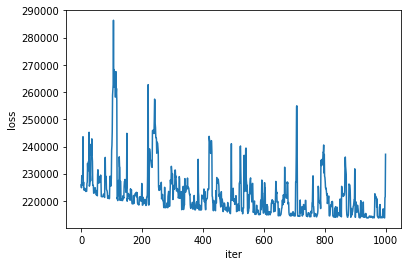

The time of execution of above program is : 410.1133482456207
theta for imputation error:  [-0.53171306848526, -0.6007848978042603]


In [12]:
start = time.time()
theta,loss_list = gradient_descent(w, y, loss_emputation, observed_e_1d, predicted_r_1d, propensities_1d, max_iter, lr)
end = time.time()
    
print("The time of execution of above program is :", end-start)
print("theta for imputation error: ", theta)

In [25]:
import pandas as pd
import numpy as np 

from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [26]:
# FM 特征组合层
class crossLayer(layers.Layer):
    def __init__(self,input_dim, output_dim=10, **kwargs):
        super(crossLayer, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.output_dim = output_dim
        # 定义交叉特征的权重
        self.kernel = self.add_weight(name='kernel', shape=(self.input_dim, self.output_dim), initializer='glorot_uniform',trainable=True)
        
    def call(self, x): # 对照上述公式中的二次项优化公式一起理解
        a = K.pow(K.dot(x, self.kernel), 2)
        b = K.dot(K.pow(x, 2), K.pow(self.kernel, 2))
        return 0.5 * K.mean(a-b, 1, keepdims=True)

# 定义FM模型
def FM(feature_dim):
    inputs = Input(shape=(feature_dim, ))
    
    # 一阶特征
    linear = Dense(units=1, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))(inputs)
    
    # 二阶特征
    cross = crossLayer(feature_dim)(inputs)
    add = Add()([linear, cross])  # 将一阶特征与二阶特征相加构建FM模型
    
    pred = add
    model = Model(inputs=inputs, outputs=pred)
    
    model.summary()
    def my_loss_fn(y_true, y_pred):
      squared_difference = tf.square(y_true - y_pred)
      return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`
    model.compile(loss=my_loss_fn,
                  optimizer=optimizers.SGD())
    
    return model    

In [27]:


# 划分训练和验证数据
# x_trn, x_tst, y_trn, y_tst = train_test_split(feats, data['Label'], test_size=0.2, random_state=2020)
x_trn = observed_features
y_trn = observed_r_1d

# 定义模型
model = FM(x_trn.shape[1])

# 训练模型
model.fit(x_trn, y_trn, epochs=10, batch_size=128, validation_data=(x_trn, y_trn))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 1)            36          ['input_3[0][0]']                
                                                                                                  
 cross_layer_2 (crossLayer)     (None, 1)            350         ['input_3[0][0]']                
                                                                                                  
 add_2 (Add)                    (None, 1)            0           ['dense_2[0][0]',                
                                                                  'cross_layer_2[0][0]']    

In [28]:
model.predict(features_matrix)

array([[ 2.7159836 ],
       [ 2.5692308 ],
       [ 2.6094303 ],
       ...,
       [-0.21834223],
       [-0.07546613],
       [-0.20598926]], dtype=float32)